In [4]:
import pandas as pd
import numpy as np
#import itertools
import sklearn.metrics as met
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import scipy as sp

import sys
sys.path.insert(0, '../../notebooks/libs/')
import FeatureExtraction as FE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import metrics

In [5]:
training = pd.read_csv('../../csv/chat_based_features_training.csv')
test = pd.read_csv('../../csv/chat_based_features_test.csv')

training_xml = '../../dataset/training/pan12-sexual-predator-identification-training-corpus-2012-05-01.xml'
test_xml = '../../dataset/test/pan12-sexual-predator-identification-test-corpus-2012-05-17.xml'

In [3]:
documents_training = FE.prepare_for_tf_idf(training_xml, False)
#documents_test = FE.prepare_for_tf_idf(test_xml, False)

tfidf=TfidfVectorizer(stop_words='english', min_df=3, max_features=2500) #max_features=2500
matrix_training=tfidf.fit_transform(documents_training)
#matrix_testing=tfidf.transform(documents_test)

column_names = training.columns.values.tolist()[1:-1]
print column_names

['number of conversation', 'percent of conversations started by the author', 'difference between two preceding lines in seconds', 'number of messages sent', 'average percent of lines in conversation', 'average percent of characters in conversation', 'number of characters sent by the author', 'mean time of messages sent', 'number of unique contacted authors', 'avg number of unique authors interacted with per conversation', 'total unique authors and unique per chat difference', 'conversation num and total unique authors difference', 'average question marks per conversations', 'total question marks', 'total author question marks', 'avg author question marks', 'author and conversation quetsion mark differnece', 'author total negative in author conv', 'author total neutral in author conv', 'author total positive in author conv', ' authortotal compound in author conv', 'pos word count author', 'neg word count author', 'prof word count author']


In [4]:
training_all = sp.sparse.hstack((training[column_names], matrix_training))
#test_all = sp.sparse.hstack((test[column_names], matrix_testing))

scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)
#test_all=scaler.transform(test_all)

In [6]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [35]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=training['is sexual predator'])
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
         show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, training['is sexual predator'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    #dtrain_predprob = alg.predict_proba(dtrain)
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(training['is sexual predator'], dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(training['is sexual predator'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('Feature importance.png', bbox_inches='tight')


Model Report
Accuracy : 1
AUC Score (Train): 1.000000


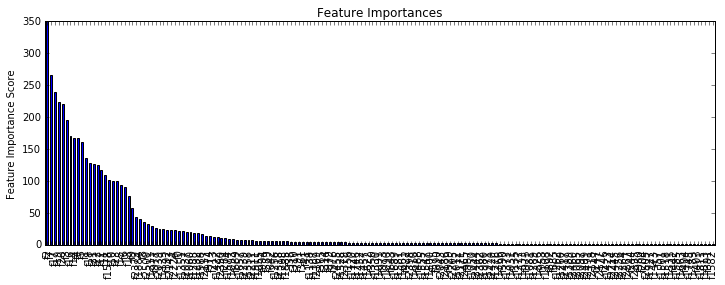

In [39]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, training_all, predictors)

In [ ]:
xgb = xgb.XGBClassifier(b_p)
xgb.fit(training_sparse_chat_based, training[['is sexual predator']])
prediction = xgb.predict(test_sparse_chat_based)

In [ ]:
print 'Accuracy: ', met.accuracy_score(test[['is sexual predator']], prediction) 
print 'Precision: ', met.precision_score(test[['is sexual predator']], prediction)
print 'Recall:', met.recall_score(test[['is sexual predator']], prediction)
print 'F1:', met.fbeta_score(test[['is sexual predator']], prediction, 1)

# XGBoost parameter tuning

In [9]:
target = 'is sexual predator'
predictors = column_names

In [6]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [9]:
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [10]:
gsearch1.fit(training_all, training[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99254, std: 0.00757, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.99166, std: 0.00663, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.99090, std: 0.00813, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.99261, std: 0.00670, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99199, std: 0.00710, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.98992, std: 0.00956, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.99037, std: 0.00969, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.99229, std: 0.00723, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.99075, std: 0.00702, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.99256, std: 0.00690, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.99182, std: 0.00760, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.99126, std: 0.00676, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [13]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[0,1,2]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(training_all, training[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.99392, std: 0.00515, params: {'max_depth': 4, 'min_child_weight': 0},
  mean: 0.99363, std: 0.00569, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.99365, std: 0.00581, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.99244, std: 0.00782, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.99261, std: 0.00670, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99266, std: 0.00785, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.99288, std: 0.00744, params: {'max_depth': 6, 'min_child_weight': 0},
  mean: 0.99198, std: 0.00759, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.99209, std: 0.00784, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 4, 'min_child_weight': 0},
 0.99391535048996382)

In [15]:
param_test2 = {
 'max_depth':[2,3,4]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(training_all, training[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.99019, std: 0.00737, params: {'max_depth': 2},
  mean: 0.99235, std: 0.00739, params: {'max_depth': 3},
  mean: 0.99392, std: 0.00515, params: {'max_depth': 4}],
 {'max_depth': 4},
 0.99391535048996382)

In [20]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(training_all, training[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99392, std: 0.00515, params: {'gamma': 0.0},
  mean: 0.99410, std: 0.00558, params: {'gamma': 0.1},
  mean: 0.99296, std: 0.00576, params: {'gamma': 0.2},
  mean: 0.99349, std: 0.00592, params: {'gamma': 0.3},
  mean: 0.99440, std: 0.00454, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.99440142418451605)

In [40]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(training_all, training[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.99048, std: 0.00834, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.99175, std: 0.00853, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.99223, std: 0.00832, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.99055, std: 0.00928, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.99157, std: 0.00854, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.99213, std: 0.00832, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.99170, std: 0.00858, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.99156, std: 0.00904, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.99186, std: 0.00825, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.99252, std: 0.00830, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.99448, std: 0.00443, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.99214, std: 0.00857, params: {'subsample': 0.9, 'colsample_bytree'

In [42]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=8,iid=False, cv=5)

gsearch5.fit(training_all, training[target])
gsearch5.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.99180, std: 0.00856, params: {'subsample': 0.75, 'colsample_bytree': 0.75},
  mean: 0.99287, std: 0.00644, params: {'subsample': 0.8, 'colsample_bytree': 0.75},
  mean: 0.99219, std: 0.00850, params: {'subsample': 0.85, 'colsample_bytree': 0.75},
  mean: 0.99403, std: 0.00475, params: {'subsample': 0.75, 'colsample_bytree': 0.8},
  mean: 0.99448, std: 0.00443, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.99243, std: 0.00804, params: {'subsample': 0.85, 'colsample_bytree': 0.8},
  mean: 0.99150, std: 0.00859, params: {'subsample': 0.75, 'colsample_bytree': 0.85},
  mean: 0.99182, std: 0.00863, params: {'subsample': 0.8, 'colsample_bytree': 0.85},
  mean: 0.99254, std: 0.00804, params: {'subsample': 0.85, 'colsample_bytree': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.99448381139708941)

In [10]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=8,iid=False, cv=5)

gsearch6.fit(training_all, training[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.99448, std: 0.00443, params: {'reg_alpha': 1e-05},
  mean: 0.99184, std: 0.00884, params: {'reg_alpha': 0.01},
  mean: 0.99145, std: 0.00883, params: {'reg_alpha': 0.1},
  mean: 0.99325, std: 0.00608, params: {'reg_alpha': 1},
  mean: 0.98209, std: 0.01492, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.99448381139708919)

In [14]:
param_test7 = {
 'reg_alpha':[1e-07, 1e-06, 1.2e-06, 2.8e-06, 2.3e-05]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-05), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=8,iid=False, cv=5)

gsearch7.fit(training_all, training[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.99448, std: 0.00443, params: {'reg_alpha': 1e-07},
  mean: 0.99448, std: 0.00443, params: {'reg_alpha': 1e-06},
  mean: 0.99448, std: 0.00443, params: {'reg_alpha': 1.2e-06},
  mean: 0.99448, std: 0.00443, params: {'reg_alpha': 2.8e-06},
  mean: 0.99448, std: 0.00443, params: {'reg_alpha': 2.3e-05}],
 {'reg_alpha': 1e-07},
 0.99448381139708941)

In [19]:
param_test8 = {
 'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=8,iid=False, cv=5)

gsearch8.fit(training_all, training[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.94567, std: 0.02004, params: {'learning_rate': 0.001},
  mean: 0.97379, std: 0.01453, params: {'learning_rate': 0.01},
  mean: 0.99448, std: 0.00443, params: {'learning_rate': 0.1},
  mean: 0.99515, std: 0.00365, params: {'learning_rate': 0.2},
  mean: 0.99530, std: 0.00346, params: {'learning_rate': 0.3}],
 {'learning_rate': 0.3},
 0.99529924297820105)

In [20]:
param_test9 = {
 'learning_rate':[0.3, 0.4, 0.5],
 'n_estimators':[100, 177, 250, 300]
}

gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.3, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07), 
 param_grid = param_test9, scoring='roc_auc',n_jobs=8,iid=False, cv=5)

gsearch9.fit(training_all, training[target])
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

([mean: 0.99516, std: 0.00373, params: {'n_estimators': 100, 'learning_rate': 0.3},
  mean: 0.99530, std: 0.00346, params: {'n_estimators': 177, 'learning_rate': 0.3},
  mean: 0.99556, std: 0.00335, params: {'n_estimators': 250, 'learning_rate': 0.3},
  mean: 0.99313, std: 0.00791, params: {'n_estimators': 300, 'learning_rate': 0.3},
  mean: 0.99232, std: 0.00847, params: {'n_estimators': 100, 'learning_rate': 0.4},
  mean: 0.99245, std: 0.00826, params: {'n_estimators': 177, 'learning_rate': 0.4},
  mean: 0.99246, std: 0.00809, params: {'n_estimators': 250, 'learning_rate': 0.4},
  mean: 0.99250, std: 0.00799, params: {'n_estimators': 300, 'learning_rate': 0.4},
  mean: 0.99337, std: 0.00781, params: {'n_estimators': 100, 'learning_rate': 0.5},
  mean: 0.99328, std: 0.00768, params: {'n_estimators': 177, 'learning_rate': 0.5},
  mean: 0.99355, std: 0.00796, params: {'n_estimators': 250, 'learning_rate': 0.5},
  mean: 0.99371, std: 0.00743, params: {'n_estimators': 300, 'learning_rate'

In [21]:
param_test10 = {
 'learning_rate':[0.29, 0.3, 0.31],
 'n_estimators':[200, 225, 250, 275]
}

gsearch10 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.3, n_estimators=177, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07), 
 param_grid = param_test10, scoring='roc_auc',n_jobs=8,iid=False, cv=5)

gsearch10.fit(training_all, training[target])
gsearch10.grid_scores_, gsearch10.best_params_, gsearch10.best_score_

([mean: 0.99169, std: 0.00836, params: {'n_estimators': 200, 'learning_rate': 0.29},
  mean: 0.99163, std: 0.00811, params: {'n_estimators': 225, 'learning_rate': 0.29},
  mean: 0.99370, std: 0.00481, params: {'n_estimators': 250, 'learning_rate': 0.29},
  mean: 0.99369, std: 0.00481, params: {'n_estimators': 275, 'learning_rate': 0.29},
  mean: 0.99547, std: 0.00336, params: {'n_estimators': 200, 'learning_rate': 0.3},
  mean: 0.99553, std: 0.00335, params: {'n_estimators': 225, 'learning_rate': 0.3},
  mean: 0.99556, std: 0.00335, params: {'n_estimators': 250, 'learning_rate': 0.3},
  mean: 0.99301, std: 0.00793, params: {'n_estimators': 275, 'learning_rate': 0.3},
  mean: 0.99126, std: 0.00818, params: {'n_estimators': 200, 'learning_rate': 0.31},
  mean: 0.99091, std: 0.00847, params: {'n_estimators': 225, 'learning_rate': 0.31},
  mean: 0.98886, std: 0.01048, params: {'n_estimators': 250, 'learning_rate': 0.31},
  mean: 0.98880, std: 0.01055, params: {'n_estimators': 275, 'learnin

# TFIDF tuning

In [8]:
target = 'is sexual predator'
column_names = training.columns.values.tolist()[1:-1]
predictors = column_names
print column_names

['number of conversation', 'percent of conversations started by the author', 'difference between two preceding lines in seconds', 'number of messages sent', 'average percent of lines in conversation', 'average percent of characters in conversation', 'number of characters sent by the author', 'mean time of messages sent', 'number of unique contacted authors', 'avg number of unique authors interacted with per conversation', 'total unique authors and unique per chat difference', 'conversation num and total unique authors difference', 'average question marks per conversations', 'total question marks', 'total author question marks', 'avg author question marks', 'author and conversation quetsion mark differnece', 'author total negative in author conv', 'author total neutral in author conv', 'author total positive in author conv', ' authortotal compound in author conv', 'pos word count author', 'neg word count author', 'prof word count author']


In [10]:
model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999088945948 stdev: 0.000166323219254


In [11]:
tfidf1=TfidfVectorizer(min_df=3, max_features=2500) #max_features=2500
matrix_training=tfidf1.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999088942805 stdev: 0.00018708844366


In [14]:
tfidf2=TfidfVectorizer() #max_features=2500
matrix_training=tfidf2.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999078705818 stdev: 0.000125396219888


In [15]:
tfidf3=TfidfVectorizer(max_features=3500) #max_features=2500
matrix_training=tfidf3.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999170838694 stdev: 0.000149741883698


In [16]:
tfidf4=TfidfVectorizer(max_features=4500) #max_features=2500
matrix_training=tfidf4.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999088946996 stdev: 0.000135019878429


In [17]:
tfidf5=TfidfVectorizer(stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf5.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999170835551 stdev: 0.000178489160482


In [20]:
tfidf6=TfidfVectorizer(min_df=0.1, stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf6.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.998945632332 stdev: 0.000184838248661


In [21]:
tfidf7=TfidfVectorizer(min_df=0.2, stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf7.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999007052154 stdev: 8.31741960043e-05


In [22]:
tfidf8=TfidfVectorizer(min_df=0.3, stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf8.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999007052154 stdev: 8.31741960043e-05


In [24]:
tfidf9=TfidfVectorizer(min_df=0.3, max_df=0.9, stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf9.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999007052154 stdev: 8.31741960043e-05


In [25]:
tfidf10=TfidfVectorizer(min_df=0.3, max_df=0.7, stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf10.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999007052154 stdev: 8.31741960043e-05


In [26]:
tfidf11=TfidfVectorizer(binary=True, stop_words='english', max_features=3500) #max_features=2500
matrix_training=tfidf11.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.998976340147 stdev: 0.000207291199574


In [28]:
tfidf12=TfidfVectorizer(binary=True, stop_words='english', max_features=3500, ngram_range=(1,2)) #max_features=2500
matrix_training=tfidf12.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999078707914 stdev: 0.00022193088611


In [29]:
tfidf13=TfidfVectorizer(stop_words='english', max_features=3500, ngram_range=(1,2)) #max_features=2500
matrix_training=tfidf13.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999119656907 stdev: 0.000122823409061


In [8]:
tfidf14=TfidfVectorizer(stop_words='english', max_features=3500, ngram_range=(1,3))
matrix_training=tfidf14.fit_transform(documents_training)
tfidf15=TfidfVectorizer(stop_words='english', max_features=3500, ngram_range=(1,2))
matrix_training1=tfidf15.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training, matrix_training1))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999109416777 stdev: 0.00016696572357


In [10]:
tfidf16=TfidfVectorizer(stop_words='english', max_features=3500, norm='l1')
matrix_training=tfidf16.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999088942805 stdev: 8.19210455261e-05


In [11]:
tfidf16=TfidfVectorizer(stop_words='english', max_features=3500, norm='l2')
matrix_training=tfidf16.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999170835551 stdev: 0.000178489160482


In [12]:
tfidf16=TfidfVectorizer(stop_words='english', max_features=3500, smooth_idf=False)
matrix_training=tfidf16.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999119652715 stdev: 0.00022521855922


In [13]:
tfidf16=TfidfVectorizer(stop_words='english', max_features=3500, sublinear_tf=True)
matrix_training=tfidf16.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999037755778 stdev: 0.000213286308414


In [32]:
training = pd.read_csv('../../csv/chat_based_features_training.csv')
test = pd.read_csv('../../csv/chat_based_features_test.csv')

training_xml = '../../dataset/training/pan12-sexual-predator-identification-training-corpus-2012-05-01.xml'
test_xml = '../../dataset/test/pan12-sexual-predator-identification-test-corpus-2012-05-17.xml'

In [14]:
minimal_number_of_messages_treshold = 10

documents_training=FE.prepare_for_tf_idf(training_xml, False, True, minimal_number_of_messages_treshold)
tfidf=TfidfVectorizer(stop_words='english', max_features=3500, sublinear_tf=True)
matrix_training=tfidf.fit_transform(documents_training)

training = training[training['number of messages sent'] 
                                      >= minimal_number_of_messages_treshold]

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.995422627301 stdev: 0.00120478892548


In [16]:
minimal_number_of_messages_treshold = 3

documents_training=FE.prepare_for_tf_idf(training_xml, True, True, minimal_number_of_messages_treshold)
tfidf=TfidfVectorizer(stop_words='english', max_features=3500, sublinear_tf=True)
matrix_training=tfidf.fit_transform(documents_training)

training = training[training['number of messages sent'] 
                                      >= minimal_number_of_messages_treshold]

training_all = sp.sparse.hstack((training[column_names], matrix_training))
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.997686293797 stdev: 0.000369598731734


In [27]:
minimal_number_of_messages_treshold = 0

training = training[training['number of messages sent'] 
                                      >= minimal_number_of_messages_treshold]

training_all = training
#scaler=StandardScaler(with_mean=False)
#training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all[column_names], training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.998904683339 stdev: 0.000139640622358


In [31]:
training = pd.read_csv('../../csv/chat_based_features_training.csv')
test = pd.read_csv('../../csv/chat_based_features_test.csv')

training_xml = '../../dataset/training/pan12-sexual-predator-identification-training-corpus-2012-05-01.xml'
test_xml = '../../dataset/test/pan12-sexual-predator-identification-test-corpus-2012-05-17.xml'

minimal_number_of_messages_treshold = 1

training = training[training['number of messages sent'] 
                                      >= minimal_number_of_messages_treshold]

training = training[training['number of conversation'] 
                                      > 1]

training_all = training
#scaler=StandardScaler(with_mean=False)
#training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all[column_names], training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.984288914558 stdev: 0.00389346009686


In [30]:
print column_names

['number of conversation', 'percent of conversations started by the author', 'difference between two preceding lines in seconds', 'number of messages sent', 'average percent of lines in conversation', 'average percent of characters in conversation', 'number of characters sent by the author', 'mean time of messages sent', 'number of unique contacted authors', 'avg number of unique authors interacted with per conversation', 'total unique authors and unique per chat difference', 'conversation num and total unique authors difference', 'average question marks per conversations', 'total question marks', 'total author question marks', 'avg author question marks', 'author and conversation quetsion mark differnece', 'author total negative in author conv', 'author total neutral in author conv', 'author total positive in author conv', ' authortotal compound in author conv', 'pos word count author', 'neg word count author', 'prof word count author']


In [33]:
tfidf16=TfidfVectorizer(stop_words='english', max_features=3500, norm='l2')
matrix_training=tfidf16.fit_transform(documents_training)

training_all = sp.sparse.hstack((training[column_names], matrix_training))
#scaler=StandardScaler(with_mean=False)
#training_all=scaler.fit_transform(training_all)

model = XGBClassifier( learning_rate = 0.3, n_estimators=250, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
    
scores = cross_validation.cross_val_score(model, training_all, training[target], cv=5)
print 'mean:',scores.mean(), 'stdev:', scores.std()

mean: 0.999047996955 stdev: 0.000166964696503



Model Report
Accuracy : 1
AUC Score (Train): 1.000000


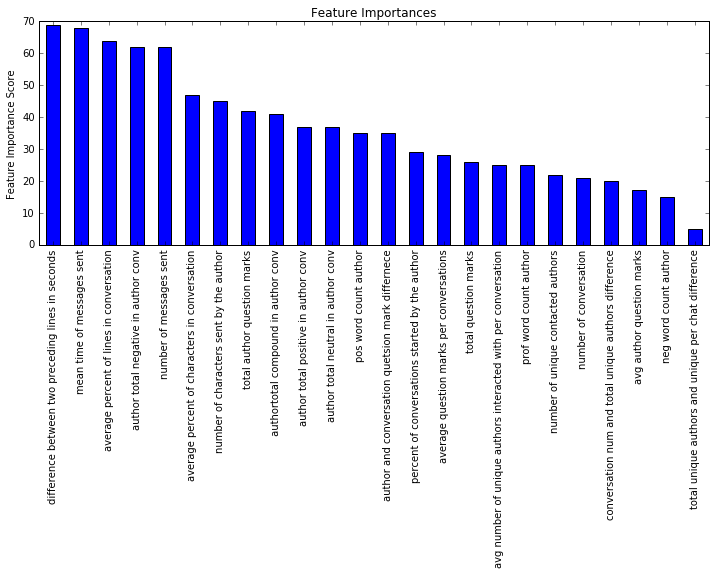

In [37]:
modelfit(model, training[column_names], predictors)